# Импорт библиотек

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# 1. Предварительная обработка данных

In [37]:
df_train = pd.read_excel('./data/train.xlsx')
df_test = pd.read_excel('./data/test.xlsx')

df_train.head()

,Unnamed: 0,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,...,status,experience,Desc_Education_5,Desc_Education_6,Education_5,Education_6,Ученая степень 2,Ученое звание 2,categories,mean_price
0,0,matematika,Репетитор по математике Емельянова Марина Вла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",...,Университетский преподаватель,31 год,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667
1,1,matematika,Репетитор по математике Назарова Анастасия Ан...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",...,Школьный преподаватель,8 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",11.666667
2,2,informatika,Репетитор по информатике Мотроненко Инна Конст...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",...,Школьный преподаватель,11 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",23.333333
3,3,matematika,Репетитор по математике Логинова Елизавета Ал...,"['Школьная программа', 'Математический анализ'...",4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",...,Частный преподаватель,5 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 1 по 4 класс', 'Школьники с 5 по...",0.116667
4,4,matematika,Репетитор по математике Харланов Олег Викторо...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",...,Частный преподаватель,19 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667


Проанализировав данные можно говорить о том, что их нужно предобработать: есть много пропусков, некоторые столбцы содержат множество значений (списки), некоторые нужны в форматировании.

In [38]:
def create_df_preprocessed(df: pd.DataFrame):
    # начнем с удаления столбца индексов
    df_preprocessed = df.copy()
    df_preprocessed.drop(columns=["Unnamed: 0"], inplace=True)
    # Всего существует 2 предмета в данном датасете: математика и информатика
    # Значит можно сделать OneHotEncoding для столбца предмет без группировки
    df_preprocessed = pd.get_dummies(df_preprocessed, columns=["предмет"])
    # Анализ ФИО вряд ли принесет значительную пользу, поэтому удалим его
    df_preprocessed.drop(columns=["ФИО"], inplace=True)
    # Столбец tutor_head_tags содержит много информации о спектре услуг.
    # Выделим сначала количество таких тэгов
    df_preprocessed["tutor_head_tags_count"] = df_preprocessed["tutor_head_tags"].apply(lambda x: len(x.split(',')))
    # Затем попробуем создать классификацию на основе тэгов.
    # По мере необходимости эту классификацию можно дополнить
    
    def olimp_class(x):
        if 'олимпиад' in x:
            return True
        else:
            return False
        
    def english_class(x):
        if 'english' in x.lower():
            return True
        else:
            return False
        
    def other_class(x):
        x_arr = x.split(',')
        x_arr_removed = x_arr.copy()
        for i in x_arr:
            if 'Школьная программа' in i or\
                'ЕГЭ' in i or\
                'ОГЭ' in i or\
                'олимпиад' in i or\
                'english' in i.lower():
                x_arr_removed.remove(i)
        if len(x_arr_removed)>0:
            return True
        else:
            return False
        
    df_preprocessed["head_olimp_class"] = df_preprocessed["tutor_head_tags"].apply(olimp_class)
    df_preprocessed['head_english_class'] = df_preprocessed["tutor_head_tags"].apply(english_class)
    df_preprocessed['head_other_class'] = df_preprocessed["tutor_head_tags"].apply(other_class)
    
    df_preprocessed.drop(columns=["tutor_head_tags"], inplace=True)
    
    # Столбцы tutor_rating и tutor_reviews форматировать не нужно, займемся description
    # description содержит ручное описание от пользователя. Вначале проанализируем, есть ли оно вообще
    
    def description_is_empty(x):
        try:
            if 'Репетитор не предоставил о себе дополнительных сведений' in x:
                return True
            else:
                return False
        except TypeError:
            return True
        
    def description_len(x):
        try:
            if 'Репетитор не предоставил о себе дополнительных сведений' in x:
                return 0
            else:
                return len(x)
        except TypeError:
            return 0
    
    df_preprocessed["description_is_empty"] = df_preprocessed["description"].apply(description_is_empty)
    #Возможно, показатель "description_length" будет полезен
    df_preprocessed["description_length"] = df_preprocessed["description"].apply(description_len)
    
    # По хорошему следовало бы прочитать эти отзывы и классифицировать их по типам (например, нейронкой), но делать этого
    # в рамках данной работы не буду (времени маловато)
    df_preprocessed.drop(columns=["description"], inplace=True)
    
    # То же самое касается и experience_desc
    def excperience_desc_is_empty(x):
        try:
            if len(x) == 0:
                return True
            else:
                return False
        except TypeError:
            return True
        
    def experience_desc_len(x):
        try:
            if len(x) == 0:
                return 0
            else:
                return len(x)
        except TypeError:
            return 0
    
    df_preprocessed["experience_desc_is_empty"] = df_preprocessed["experience_desc"].apply(excperience_desc_is_empty)
    df_preprocessed["experience_desc_length"] = df_preprocessed["experience_desc"].apply(experience_desc_len)
    df_preprocessed.drop(columns=["experience_desc"], inplace=True)
    
    # Для education_1 хочется реализовать поиск по рейтингу вуза, однако сделаю это позже (если найду нужную БД)
    df_preprocessed.drop(columns=["Education_1"], inplace=True)
    
    # Для education_2 нужно вытащить год окончания
    def year_of_graduation(x):
        try:
            x_arr = x.split(',')
        except AttributeError:
            return 0
        for i in x_arr[0].split(': '):
            try: 
                return int(i)
            except ValueError:
                pass
        return 0
    
    df_preprocessed["year_of_graduation_1"] = df_preprocessed["Desc_Education_1"].apply(year_of_graduation)
    df_preprocessed.drop(columns=["Desc_Education_1"], inplace=True)
    
    # Из education 2 лучше взять только его наличие или отсутствие
    df_preprocessed['education_2'] = df_preprocessed['Education_2'].apply(lambda x: False if x is np.nan else True)
    df_preprocessed.drop(columns=['Education_2'], inplace=True)
    
    df_preprocessed["year_of_graduation_2"] = df_preprocessed["Desc_Education_2"].apply(year_of_graduation)
    df_preprocessed.drop(columns=["Desc_Education_2"], inplace=True)
    
    # Есть столбцы education 3 и т. д., их обрабатываем точно также
    df_preprocessed['education_3'] = df_preprocessed['Education_3'].apply(lambda x: False if x is np.nan else True)
    df_preprocessed.drop(columns=['Education_3'], inplace=True)
    
    df_preprocessed["year_of_graduation_3"] = df_preprocessed["Desc_Education_3"].apply(year_of_graduation)
    df_preprocessed.drop(columns=["Desc_Education_3"], inplace=True)
    
    df_preprocessed['education_4'] = df_preprocessed['Education_4'].apply(lambda x: False if x is np.nan else True)
    df_preprocessed.drop(columns=['Education_4'], inplace=True)
    
    df_preprocessed["year_of_graduation_4"] = df_preprocessed["Desc_Education_4"].apply(year_of_graduation)
    df_preprocessed.drop(columns=["Desc_Education_4"], inplace=True)
    
    df_preprocessed['education_5'] = df_preprocessed['Education_5'].apply(lambda x: False if x is np.nan else True)
    df_preprocessed.drop(columns=['Education_5'], inplace=True)
    
    df_preprocessed["year_of_graduation_5"] = df_preprocessed["Desc_Education_5"].apply(year_of_graduation)
    df_preprocessed.drop(columns=["Desc_Education_5"], inplace=True)
    
    df_preprocessed['education_6'] = df_preprocessed['Education_6'].apply(lambda x: False if x is np.nan else True)
    df_preprocessed.drop(columns=['Education_6'], inplace=True)
    
    df_preprocessed["year_of_graduation_6"] = df_preprocessed["Desc_Education_6"].apply(year_of_graduation)
    df_preprocessed.drop(columns=["Desc_Education_6"], inplace=True)
    
    # Из столбца ученой степени вытянем ее наличие и зафиксируем ее в виде словаря
    # {nan: 0, 'кандидат наук': 1, 'доктор наук': 2}
    # Если признак окажется важным, то такое деление поможет модели понять, что кандидат наук выше доктора наук
    def academic_degree(x):
        if x is np.nan:
            return 0
        elif 'кандидат' in x.lower():
            return 1
        elif 'доктор' in x.lower():
            return 2
        else:
            return 0
        
    df_preprocessed['academic_degree'] = df_preprocessed['Ученая степень 1'].apply(academic_degree)
    df_preprocessed.drop(columns=['Ученая степень 1'], inplace=True)
    
    # По аналогии с ученой степенью делаем и с ученым званием
    # {nan: 0, 'научный сотрудник': 1, 'доцент': 2, 'профессор': 3}
    def academic_rank(x):
        if x is np.nan:
            return 0
        elif 'научный сотрудник' in x.lower():
            return 1
        elif 'доцент' in x.lower():
            return 2
        elif 'профессор' in x.lower():
            return 3
        else:
            return 0
        
    df_preprocessed['academic_rank'] = df_preprocessed['Ученое звание 1'].apply(academic_rank)
    df_preprocessed.drop(columns=['Ученое звание 1'], inplace=True)
    
    # ученая степень 2 мусорный столбец - он у всех пустой
    df_preprocessed.drop(columns=['Ученое звание 2'], inplace=True)
    df_preprocessed.drop(columns=['Ученая степень 2'], inplace=True)
    
    # В поле статуса все примерно так же, как и в классификации по тэгам:
    # есть несколько разных классов, которые встречаются в разных вариациях. Сделаем как в методичке
    dummies = df_preprocessed['status'].str.get_dummies(sep=',')
    df_preprocessed = df_preprocessed.join(dummies, how='left')
    df_preprocessed.drop(columns=['status'], inplace=True)
    
    # Со столбцом experience тоже можно сделать так, как в методичке
    df_preprocessed['experience'] = df_preprocessed['experience'].str.replace(r"[^\d\.]", "", regex=True)
    df_preprocessed['experience'] = df_preprocessed['experience'].astype('float64')
    
    # Ввиду малого количества времени сделаем так же с categories
    # посмотрев на результат сразу понятно, что он отвратительный, но исправлять не охота
    df_preprocessed['categories'] = df_preprocessed['categories'].apply(lambda s: list(ast.literal_eval(s)))
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df_preprocessed['categories'])
    genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
    df_preprocessed = pd.concat([df_preprocessed, genres_df], axis=1)
    
    df_preprocessed.drop(columns=['categories'], inplace=True)
    
    # Формируем столбец с максимальным годом окончания обучения
    df_preprocessed['max_year_of_graduation'] = df_preprocessed[['year_of_graduation_1', 'year_of_graduation_2',
                      'year_of_graduation_3', 'year_of_graduation_4',
                      'year_of_graduation_5', 'year_of_graduation_6']].max(axis=1)
    df_preprocessed.drop(columns=['year_of_graduation_1', 'year_of_graduation_2',
                                  'year_of_graduation_3', 'year_of_graduation_4', 
                                  'year_of_graduation_5', 'year_of_graduation_6'], inplace=True)
    return df_preprocessed

In [39]:
df_train_preprocessed = create_df_preprocessed(df_train)
df_train_preprocessed.head()

,tutor_rating,tutor_reviews,experience,mean_price,предмет_informatika,предмет_matematika,tutor_head_tags_count,head_olimp_class,head_english_class,head_other_class,...,Школьники с 1 по 4 класс,Школьники с 1 по 4 класс в паре,Школьники с 1 по 4 класс группа,"Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты","Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты в паре","Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты группа",Школьники с 5 по 9 класс,Школьники с 5 по 9 класс в паре,Школьники с 5 по 9 класс группа,max_year_of_graduation
0,5.0,2,31.0,16.666667,False,True,3,False,False,False,...,0,0,0,1,0,0,1,0,0,1990
1,4.0,7,8.0,11.666667,False,True,3,False,False,False,...,0,0,0,1,0,0,1,0,0,2023
2,0.0,0,11.0,23.333333,True,False,3,False,False,False,...,0,0,0,1,0,0,1,0,0,2014
3,4.0,19,5.0,0.116667,False,True,8,False,False,True,...,1,0,0,1,0,0,1,0,0,2021
4,0.0,0,19.0,16.666667,False,True,3,False,False,False,...,0,0,0,1,0,0,1,0,0,2005


# 2. Разведовательный анализ

<Axes: >

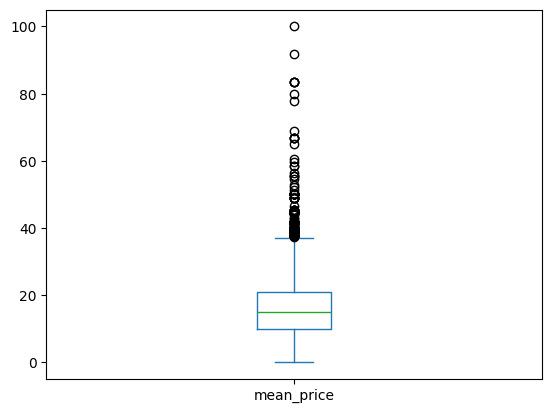

In [40]:
# В первую очередь проведем анализ целевой переменной
df_train_preprocessed['mean_price'].plot.box()

Получаем те же данные, что и в бэйзлайн решении. Следовательно, нужно решать проблему выбросов в данных. Т. к. выбросов достаточно много, кажется логичным использовать логарифмирование, как метод борьбы с выбросами.

Skewness до: 1.3051591607295885
Skewness после: -1.6128317350593795


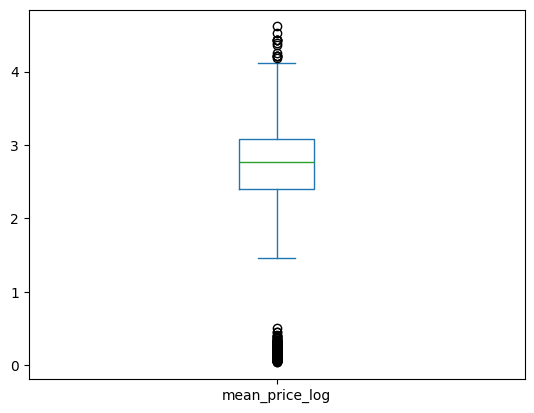

In [41]:
df_train_preprocessed['mean_price_log'] = np.log1p(df_train_preprocessed['mean_price'])
df_train_preprocessed['mean_price_log'].plot.box()
print("Skewness до:", df_train_preprocessed['mean_price'].skew())
print("Skewness после:", df_train_preprocessed['mean_price_log'].skew())
df_train_preprocessed.drop(['mean_price_log'], axis=1, inplace=True)

Попытки логарифмировать данный столбец ни к чему не привели. Следовательно, используем немного другой метод - обрежем данные по верхнему пределу и по нижнему.

In [42]:
# Вычисляем сильные выбросы
train_mean = df_train_preprocessed['mean_price'].mean()
train_std = df_train_preprocessed['mean_price'].std()
# Будем считать выбросами все, что больше 2,5
df_train_preprocessed['is_premium'] = ((df_train_preprocessed['mean_price'] - train_mean) / train_std > 2.5).astype(int)
# Выбросов вниз не обнаружено

q1 = np.percentile(df_train_preprocessed['mean_price'].values, 1)
q3 = np.percentile(df_train_preprocessed['mean_price'].values, 99)
df_train_preprocessed.drop(df_train_preprocessed.loc[df_train_preprocessed['mean_price'] < q1].index, inplace=True)

Далее проверим количественные переменные на связь с целевой переменной и мультикооллинеарность.

<Axes: >

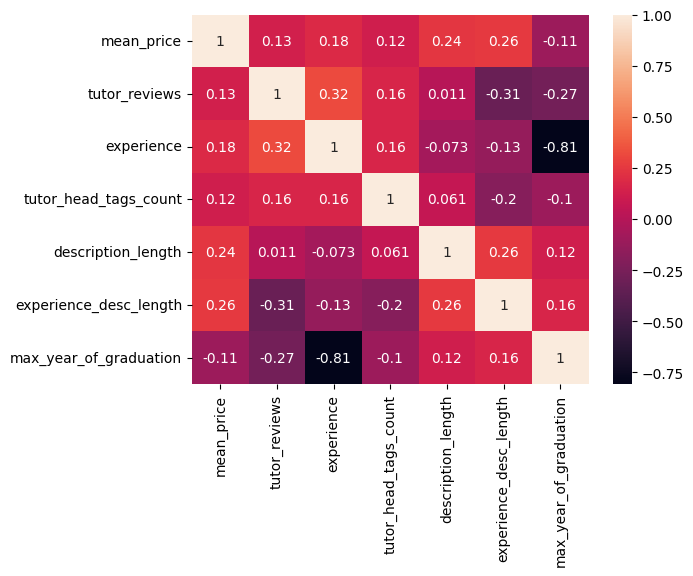

In [43]:
sns.heatmap(df_train_preprocessed[['mean_price', 'tutor_reviews', 'experience', 
                       'tutor_head_tags_count', 'description_length',
                       'experience_desc_length', 'max_year_of_graduation']].corr(method='spearman'), annot=True)

Из данного анализа видно, что наибольшее влияние на среднюю цену сильно оказывает длина описания (как опыта, так и обычное описание). При этом присутствует мультиколлинеарность между количеством отзывов и длиной описания, однако она недостаточно сильная для того, чтобы исключать один из столбцов. Однако, запомним это в будущем анализе. 

In [44]:
df_train_preprocessed

,tutor_rating,tutor_reviews,experience,mean_price,предмет_informatika,предмет_matematika,tutor_head_tags_count,head_olimp_class,head_english_class,head_other_class,...,Школьники с 1 по 4 класс в паре,Школьники с 1 по 4 класс группа,"Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты","Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты в паре","Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты группа",Школьники с 5 по 9 класс,Школьники с 5 по 9 класс в паре,Школьники с 5 по 9 класс группа,max_year_of_graduation,is_premium
0,5.0,2,31.0,16.666667,False,True,3,False,False,False,...,0,0,1,0,0,1,0,0,1990,0
1,4.0,7,8.0,11.666667,False,True,3,False,False,False,...,0,0,1,0,0,1,0,0,2023,0
2,0.0,0,11.0,23.333333,True,False,3,False,False,False,...,0,0,1,0,0,1,0,0,2014,0
3,4.0,19,5.0,0.116667,False,True,8,False,False,True,...,0,0,1,0,0,1,0,0,2021,0
4,0.0,0,19.0,16.666667,False,True,3,False,False,False,...,0,0,1,0,0,1,0,0,2005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,4.0,11,5.0,16.666667,False,True,7,False,False,True,...,0,0,1,0,0,1,0,0,2020,0
4544,0.0,0,30.0,33.333333,True,False,3,False,False,False,...,0,0,0,0,0,1,0,0,1979,0
4545,0.0,0,6.0,23.333333,True,False,3,False,False,False,...,0,0,1,0,0,1,0,0,2020,0
4546,0.0,0,1.0,9.722222,True,False,3,False,False,False,...,0,0,1,0,0,1,0,0,2026,0


Далее проведем анализ dummy-переменных. Для этого разделим выборку на 2: где будет dummy-переменная и где нет. Если в них обнаружаться статистически значимые различия (определим это по t-тесту), то это будет означать, что dummy-переменная влияет на целевую переменную.

In [45]:
# По предмету
for dummy_col in ['предмет_informatika', 'предмет_matematika']:
    if dummy_col in df_train_preprocessed.columns:
        # T-тест
        group0 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 0]['mean_price']
        group1 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 1]['mean_price']
        t_stat, p_val = stats.ttest_ind(group0, group1)
        print(f"{dummy_col}: p-value = {p_val}")
        
print('Т. к. p-value < 0.05, то гипотеза о равенстве средних отвергается')

предмет_informatika: p-value = 2.0725985300111924e-13
предмет_matematika: p-value = 2.0725985300111924e-13
Т. к. p-value < 0.05, то гипотеза о равенстве средних отвергается


In [46]:
# По целевой аудитории
for dummy_col in ['head_school_class', 'head_olimp_class', 'head_english_class',
       'head_other_class']:
    if dummy_col in df_train_preprocessed.columns:
        # T-тест
        group0 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 0]['mean_price']
        group1 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 1]['mean_price']
        t_stat, p_val = stats.ttest_ind(group0, group1)
        print(f"{dummy_col}: p-value = {p_val}")
        
print('Здесь p-value > 0.05 лишь у дополнительных предметов, значит, следует его исключить')

head_olimp_class: p-value = 2.467762942303102e-10
head_english_class: p-value = 1.8097070210187788e-16
head_other_class: p-value = 0.7095764393790948
Здесь p-value > 0.05 лишь у дополнительных предметов, значит, следует его исключить


In [47]:
# Статус преподавателя
for dummy_col in [' Аспирант или ординатор очной формы обучения',
       ' Студент', ' Университетский преподаватель', ' Частный преподаватель',
       ' Школьный преподаватель']:
    if dummy_col in df_train_preprocessed.columns:
        # T-тест
        group0 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 0]['mean_price']
        group1 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 1]['mean_price']
        t_stat, p_val = stats.ttest_ind(group0, group1)
        print(f"{dummy_col}: p-value = {p_val}")
        
print('Здесь p-value < 0.05 значит, статистически значимые различия имеются')

 Аспирант или ординатор очной формы обучения: p-value = 2.0871267824985316e-08
 Студент: p-value = 5.425866731784041e-34
 Университетский преподаватель: p-value = 3.875142632432914e-10
 Частный преподаватель: p-value = 3.919285876512115e-08
 Школьный преподаватель: p-value = 1.0902417440183733e-11
Здесь p-value < 0.05 значит, статистически значимые различия имеются


In [48]:
# Целевая аудитория
for dummy_col in ['Взрослые кроме абитуриентов и студентов',
       'Взрослые кроме абитуриентов и студентов в паре',
       'Взрослые кроме абитуриентов и студентов группа', 'Дошкольники',
       'Дошкольники в паре', 'Дошкольники группа', 'Студенты университетов',
       'Студенты университетов в паре', 'Школьники с 1 по 4 класс',
       'Школьники с 1 по 4 класс в паре', 'Школьники с 1 по 4 класс группа',
       'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты',
       'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты в паре',
       'Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты группа',
       'Школьники с 5 по 9 класс', 'Школьники с 5 по 9 класс в паре',
       'Школьники с 5 по 9 класс группа']:
    if dummy_col in df_train_preprocessed.columns:
        # T-тест
        group0 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 0]['mean_price']
        group1 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 1]['mean_price']
        t_stat, p_val = stats.ttest_ind(group0, group1)
        print(f"{dummy_col}: p-value = {p_val}")
        
print('Из дальнейшего анализа стоит удалить Дошкольники в паре, Дошкольники группа, Школьники с 1 по 4 класс группа')

Взрослые кроме абитуриентов и студентов: p-value = 0.0008895633738504352
Взрослые кроме абитуриентов и студентов в паре: p-value = 9.294105687987663e-09
Взрослые кроме абитуриентов и студентов группа: p-value = 0.023831790572883035
Дошкольники: p-value = 1.2306415873996446e-11
Дошкольники в паре: p-value = 0.6743070496870465
Дошкольники группа: p-value = 0.17177975248163008
Студенты университетов: p-value = 0.026853108140248595
Студенты университетов в паре: p-value = 7.366985666992822e-05
Школьники с 1 по 4 класс: p-value = 1.445708560087121e-12
Школьники с 1 по 4 класс в паре: p-value = 0.007458630406026271
Школьники с 1 по 4 класс группа: p-value = 0.6776092759688632
Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты: p-value = 7.117337421468627e-28
Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты в паре: p-value = 4.8527265261102633e-32
Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты группа: p-value = 4.43233061

In [49]:
# Другие переменные
for dummy_col in ['is_premium', 'description_is_empty', 'education_2',
       'education_3', 'education_4', 'education_5', 
       'education_6', 'experience_desc_is_empty']:
    if dummy_col in df_train_preprocessed.columns:
        # T-тест
        group0 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 0]['mean_price']
        group1 = df_train_preprocessed[df_train_preprocessed[dummy_col] == 1]['mean_price']
        t_stat, p_val = stats.ttest_ind(group0, group1)
        print(f"{dummy_col}: p-value = {p_val}")
        
print('Из дальнейшего анализа можно убрать все образования, после третьего')

is_premium: p-value = 7.689211973163266e-274
description_is_empty: p-value = 4.4586002157618477e-29
education_2: p-value = 3.350963859815243e-16
education_3: p-value = 0.00552856877700044
education_4: p-value = 0.5364634331196401
education_5: p-value = 0.07922422811496596
education_6: p-value = 0.12231058828704718
experience_desc_is_empty: p-value = 1.487096313615838e-46
Из дальнейшего анализа можно убрать все образования, после третьего


Список на исключение:
1) head_other_class
2) 'Дошкольники в паре', 'Дошкольники группа', 'Школьники с 1 по 4 класс группа', education_4, education_5, education_6

Возможные списки на исключение 
1) max_year_of_graduation, tutor_head_tags_count, tutor_review

In [50]:
# Проверим важность оставшихся признаков через случайный лес

X = df_train_preprocessed.drop(columns=['mean_price', 'head_other_class', 'Дошкольники в паре', 'Дошкольники группа', 
                                        'Школьники с 1 по 4 класс группа', 'education_4', 'education_5', 'education_6'])

# Кодируем целевую переменную
y = df_train_preprocessed['mean_price']

# Обучаем модель
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Важность признаков
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print('Самые важные признаки:\n', importance.loc[importance>0.01])

Самые важные признаки:
 is_premium                                                                  0.256165
description_length                                                          0.135525
experience                                                                  0.096839
max_year_of_graduation                                                      0.095863
experience_desc_length                                                      0.093185
tutor_reviews                                                               0.061928
tutor_head_tags_count                                                       0.043702
tutor_rating                                                                0.024009
education_2                                                                 0.016718
Школьники с 10 по 11 класс, студенты колледжей и техникумов, абитуриенты    0.015096
Школьники с 1 по 4 класс                                                    0.013398
 Студент                                 

In [51]:
# Заполним пропуски
df_train_preprocessed['tutor_rating'] = df_train_preprocessed['tutor_rating'].fillna(0)
df_train_preprocessed['experience'] = df_train_preprocessed['experience'].fillna(df_train_preprocessed['experience'].mean())

# Моделирование

## 1. Рандомный лес
Причина выбора этого алгоритма в том, что он устойчив к выбросам, а т. к. в целевой переменной они есть, стоит попробовать сначала его

In [52]:
X = df_train_preprocessed.drop(columns=['mean_price', 'head_other_class', 'Дошкольники в паре', 'Дошкольники группа', 
                                        'Школьники с 1 по 4 класс группа', 'education_4', 'education_5', 'education_6',
                                        ' Частный преподаватель', ' Школьный преподаватель', 'max_year_of_graduation', 
                                        'is_premium'])

y = df_train_preprocessed['mean_price']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline_random_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_random_forest = {
    'regressor__n_estimators': [50, 100, 200, 300, 400],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid = GridSearchCV(pipeline_random_forest, param_grid_random_forest, cv=3, scoring='neg_mean_squared_error', 
                   n_jobs=-1)

grid.fit(X_train, y_train)
print(f"Лучшие параметры: {grid.best_params_}")
print(f"Лучшая MSE: {grid.best_score_:.3f}")

Лучшие параметры: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 400}
Лучшая MSE: -78.345


In [53]:
pipeline_random_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, max_depth=20, max_features='sqrt', 
                                        min_samples_leaf=2, min_samples_split=2, n_estimators=400))
])

pipeline_random_forest.fit(X_train, y_train)
y_pred = pipeline_random_forest.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))

MSE:  86.49403251173338


Вторая модель, которую имеет смысл проверить - это XGBoost, т.к. она также устойчива к выбросам и хорошо себя показывает в задачах регрессии.

In [54]:
pipeline_xgboost = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

# Параметры для GridSearch
param_grid_xgboost = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [0, 0.1, 1]
}

# Настройка GridSearch
grid_xgboost = GridSearchCV(
    estimator=pipeline_xgboost,
    param_grid=param_grid_xgboost,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
)

# Обучение модели
grid_xgboost.fit(X_train, y_train)

# Лучшие параметры
print(f"Лучшие параметры: {grid_xgboost.best_params_}")
print(f"Лучшая MSE: {grid_xgboost.best_score_:.3f}")

Лучшие параметры: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 1, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}
Лучшая MSE: -81.269


In [55]:
pipeline_xgboost = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1, colsample_bytree=1.0, 
                         gamma=0, learning_rate=0.01, max_depth=7, n_estimators=300, 
                         subsample=0.8, reg_alpha=0, reg_lambda=0
                         ))
])

pipeline_xgboost.fit(X_train, y_train)
y_pred = pipeline_xgboost.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))

MSE:  85.2586396074149


Т. к. XGBoost дал недостаточно высокий уровень точности, используем аса

In [56]:

X = df_train_preprocessed.drop(columns=['mean_price', 'head_other_class', 'Дошкольники в паре', 'Дошкольники группа', 
                                        'Школьники с 1 по 4 класс группа', 'education_4', 'education_5', 'education_6',
                                        ' Частный преподаватель', ' Школьный преподаватель', 'max_year_of_graduation', 
                                        'is_premium', 'Взрослые кроме абитуриентов и студентов группа'])

y = df_train_preprocessed['mean_price']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

base_models = [
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1, colsample_bytree=1.0, 
                         gamma=0, learning_rate=0.01, max_depth=7, n_estimators=300, 
                         subsample=0.8, reg_alpha=0, reg_lambda=0
                         )),
    ('svr', Pipeline([('scaler', StandardScaler()), ('svr', SVR())])),
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(),
    cv=5
)

stacking_model.fit(X_train, y_train)

# Оцените производительность
from sklearn.metrics import mean_squared_error
y_pred = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Stacking MSE: {mse:.3f}")

Stacking MSE: 85.451


# Предсказание

In [57]:
df_test_preprocessed = create_df_preprocessed(df_test)
df_test_preprocessed['experience'] = df_test_preprocessed['experience'].fillna(df_test_preprocessed['experience'].mean())
df_test_preprocessed['tutor_rating'] = df_test_preprocessed['tutor_rating'].fillna(0)
df_test_preprocessed['tutor_reviews'] = df_test_preprocessed['tutor_reviews'].fillna(0)
X_validate = df_test_preprocessed.drop(columns=['head_other_class', 'Дошкольники в паре', 'Дошкольники группа', 
                                        'Школьники с 1 по 4 класс группа', 'education_4', 'education_5', 'education_6',
                                        ' Частный преподаватель', ' Школьный преподаватель', 'max_year_of_graduation', 
                                        'Студенты университетов группа'])

y_pred = stacking_model.predict(X_validate)


In [58]:
pd.DataFrame(y_pred, columns=["mean_price"]).to_csv("./data/y_pred.csv")

# Скриншот турнирной таблицы Kaggle

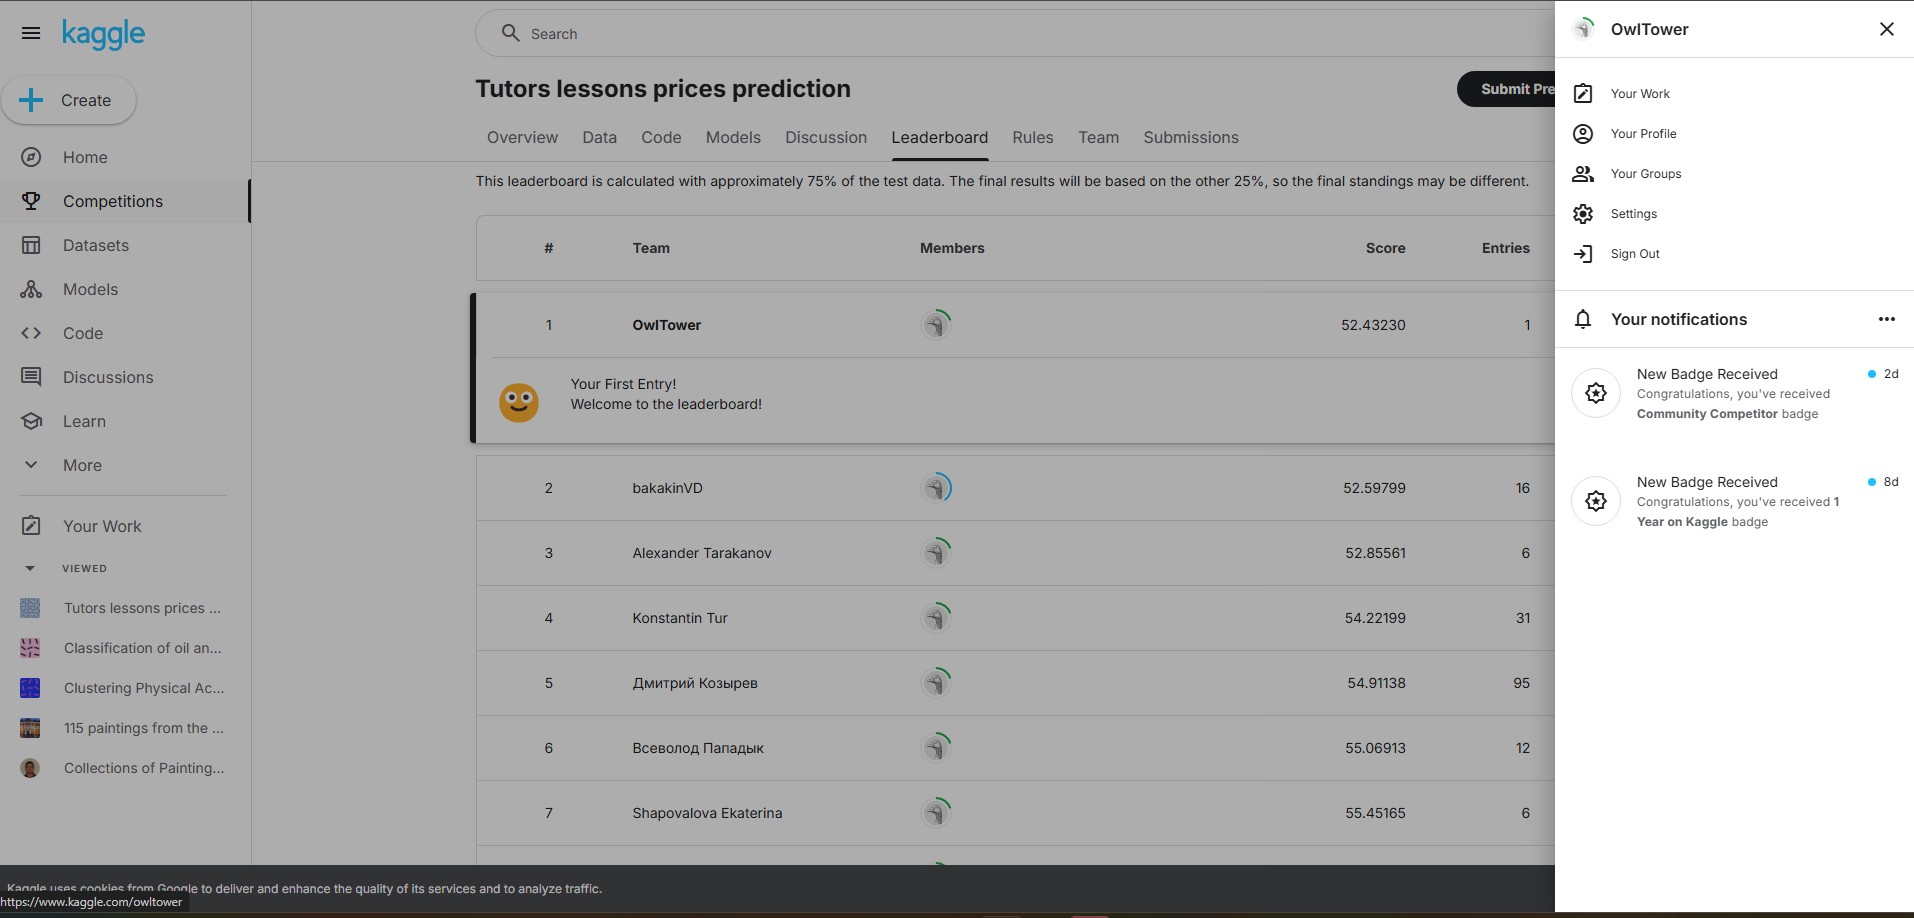